# Introduction

https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction?resource=download

## Dependencies

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

## Data Pre-Processing

I will replace the null values with -1. This is to allow the network to still make calculations with those values given the algorith used in learning (back-propagation) while also allowing the network to learn there is a possible association between those missing values. -1 is not a meaningful or actual value in the dataset prior to imputation.

In [3]:
#read in data from uploaded file
train_recode = pd.read_csv("train_recode.csv")
test_recode = pd.read_csv("test_recode.csv")
#drop repeated columns
# Age, Gender, ICUType, and height_cleaned are all demographic unchanging variables, due to the way this was initially transposed these were
#duplicated and thus are removed here. MechVent was removed because MechVent_cleaned was used instead.
train_recode_rem = train_recode.drop(["Age_2", "Age_3", "Age_4", "Gender_2", "Gender_3", "Gender_4", "ICUType_2", "ICUType_3", "ICUType_4", "MechVent_1", "MechVent_2", "MechVent_3", "MechVent_4", "height_cleaned_2", "height_cleaned_3", "height_cleaned_4"], axis = 1)
test_recode_rem = test_recode.drop(["Age_2", "Age_3", "Age_4", "Gender_2", "Gender_3", "Gender_4", "ICUType_2", "ICUType_3", "ICUType_4", "MechVent_1", "MechVent_2", "MechVent_3", "MechVent_4", "height_cleaned_2", "height_cleaned_3", "height_cleaned_4"], axis = 1)
#This replaces NA values with -1
train_rem_neg1 = train_recode_rem.fillna(-1)
test_rem_neg1 = test_recode_rem.fillna(-1)


In [4]:
train_x = train_rem_neg1.drop(["subjid", "In.hospital_death"], axis = 1)
train_y = train_rem_neg1["In.hospital_death"]

## Model Build 1

In [5]:
# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
n_features1 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [7]:
model1 = models.Sequential(name="Model1", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features1,
                 units=int(round((n_features1+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features1+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 77)                11858     
                                                                 
 drop1 (Dropout)             (None, 77)                0         
                                                                 
 h2 (Dense)                  (None, 38)                2964      
                                                                 
 drop2 (Dropout)             (None, 38)                0         
                                                                 
 output (Dense)              (None, 1)                 39        
                                                                 
Total params: 14,861
Trainable params: 14,861
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the neural network
random.seed(749)
model1.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

Epoch 1/100
28/28 [==============================] - 2s 15ms/step - loss: 10.9984 - accuracy: 0.7705 - F1: 0.1533 - val_loss: 7.9152 - val_accuracy: 0.8740 - val_F1: 0.0859
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 7.0886 - accuracy: 0.7897 - F1: 0.2645 - val_loss: 5.7642 - val_accuracy: 0.8766 - val_F1: 0.0935
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 3.7580 - accuracy: 0.8043 - F1: 0.2689 - val_loss: 4.4160 - val_accuracy: 0.8740 - val_F1: 0.0871
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 3.3567 - accuracy: 0.7750 - F1: 0.2217 - val_loss: 4.3483 - val_accuracy: 0.8740 - val_F1: 0.0859
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 4.0362 - accuracy: 0.8223 - F1: 0.2605 - val_loss: 3.5834 - val_accuracy: 0.8898 - val_F1: 0.1306
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 4.0355 - accuracy: 0.7885 - F1: 0.2226 - val_loss: 2.5969 - val_accura

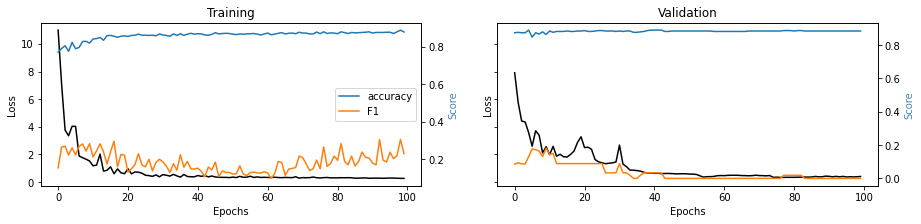

In [9]:
# train/validation
training1 = model1.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=1, validation_split=0.3)

# plot
metrics = [k for k in training1.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training1.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training1.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training1.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training1.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Model Build 2

In [10]:
n_features2 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [11]:
model2 = models.Sequential(name="Model2", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features2,
                 units=int(round((n_features2+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 77)                11858     
                                                                 
 drop1 (Dropout)             (None, 77)                0         
                                                                 
 output (Dense)              (None, 1)                 78        
                                                                 
Total params: 11,936
Trainable params: 11,936
Non-trainable params: 0
_________________________________________________________________


In [12]:
# compile the neural network
random.seed(371912)
model2.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

Epoch 1/100
28/28 [==============================] - 1s 13ms/step - loss: 14.4810 - accuracy: 0.7593 - F1: 0.1475 - val_loss: 5.1957 - val_accuracy: 0.8478 - val_F1: 0.1139
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 7.1315 - accuracy: 0.8020 - F1: 0.2797 - val_loss: 8.9034 - val_accuracy: 0.8845 - val_F1: 0.0185
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 6.9470 - accuracy: 0.8313 - F1: 0.3446 - val_loss: 5.6744 - val_accuracy: 0.8845 - val_F1: 0.1083
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 4.9671 - accuracy: 0.8223 - F1: 0.3450 - val_loss: 5.7258 - val_accuracy: 0.8898 - val_F1: 0.2137
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 3.9946 - accuracy: 0.8268 - F1: 0.3464 - val_loss: 4.8405 - val_accuracy: 0.8871 - val_F1: 0.1306
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 3.6287 - accuracy: 0.8234 - F1: 0.3266 - val_loss: 6.1238 - val_accura

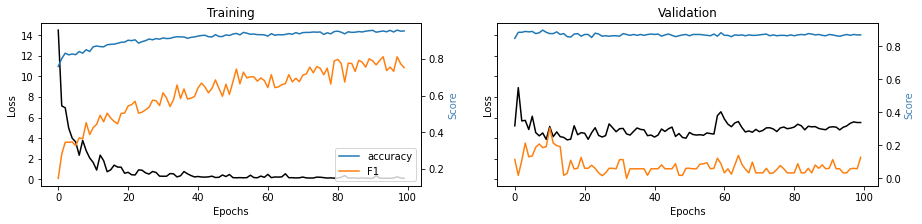

In [13]:
# train/validation
training2 = model2.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=1, validation_split=0.3)

# plot
metrics = [k for k in training1.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training2.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training2.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training2.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training2.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Model Build 3

In [14]:
n_features3 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [15]:
model3 = models.Sequential(name="Model3", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features3,
                 units=n_features3, 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model3.summary()

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 153)               23562     
                                                                 
 drop1 (Dropout)             (None, 153)               0         
                                                                 
 output (Dense)              (None, 1)                 154       
                                                                 
Total params: 23,716
Trainable params: 23,716
Non-trainable params: 0
_________________________________________________________________


In [17]:
# compile the neural network
random.seed(371912)
model3.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

Epoch 1/100
28/28 [==============================] - 1s 14ms/step - loss: 24.0837 - accuracy: 0.7638 - F1: 0.1042 - val_loss: 10.6742 - val_accuracy: 0.7165 - val_F1: 0.2431
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 9.1612 - accuracy: 0.7897 - F1: 0.2256 - val_loss: 8.1340 - val_accuracy: 0.8766 - val_F1: 0.0602
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 7.0853 - accuracy: 0.8065 - F1: 0.2663 - val_loss: 5.0257 - val_accuracy: 0.8688 - val_F1: 0.1902
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 5.1582 - accuracy: 0.7964 - F1: 0.2760 - val_loss: 6.8030 - val_accuracy: 0.8871 - val_F1: 0.0889
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 5.1246 - accuracy: 0.8245 - F1: 0.3033 - val_loss: 5.9553 - val_accuracy: 0.8898 - val_F1: 0.1556
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 4.1255 - accuracy: 0.8335 - F1: 0.3741 - val_loss: 8.7416 - val_accur

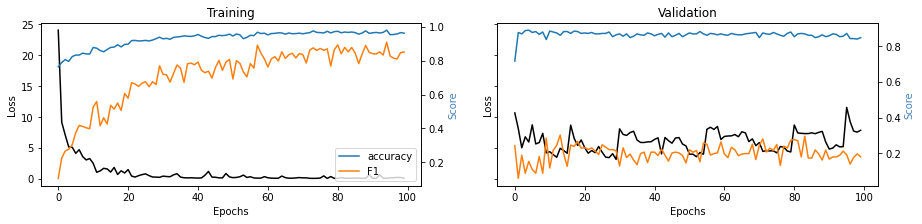

In [19]:
# train/validation
training3 = model3.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=1, validation_split=0.3)

# plot
metrics = [k for k in training3.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training3.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training3.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training3.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training3.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Evaluation

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve
import seaborn as sns

In [20]:
test_x = test_rem_neg1.drop(["subjid", "In.hospital_death"], axis = 1)
test_y = test_rem_neg1["In.hospital_death"]

In [22]:
predictions_NN_prob = model1.predict(test_x)
predictions_NN_prob = predictions_NN_prob[:,0]
# use 0.13 as threshold because that is the approximate prevalence in the data of death
predictions_NN_01 = np.where(predictions_NN_prob > 0.13, 1, 0) #Turn probability to 0-1 binary output

18/18 [==============================] - 0s 2ms/step


In [23]:
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.691743119266055


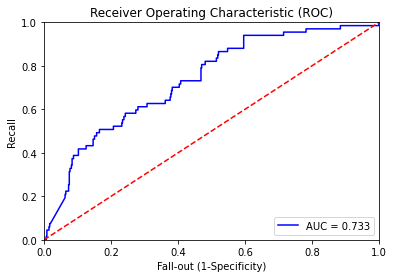

In [24]:
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

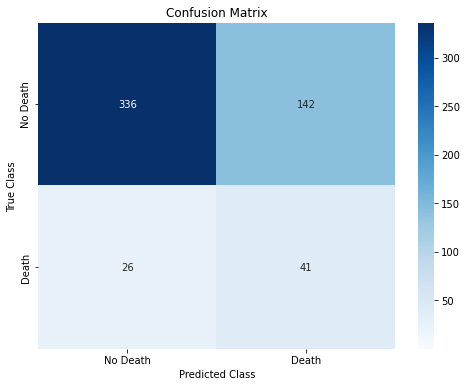

In [25]:
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['No Death', 'Death']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

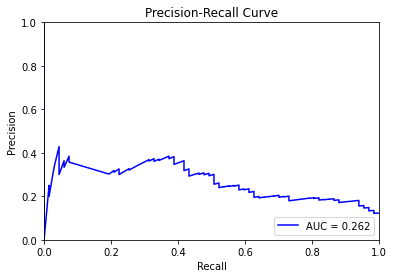

In [26]:
precision, recall, thresholds = precision_recall_curve(test_y, predictions_NN_prob)
prc_auc = auc(recall, precision)
plt.figure()
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.3f' %prc_auc)
plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Conclusion